In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

from Tools.config_helpers import loadConfig, make_small
from klepto.archives import dir_archive

from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
from coffea import processor, hist

from processor.trilep_ttZ_analysis import trilep_ttZ_analysis
from processor.default_accumulators import desired_output, add_processes_to_output, variations

In [3]:
# an equivalent code can be run with ipython -i trilep_ttZ_analysis.py within the processor directory

from Tools.samples import fileset_2018, fileset_2018_small

overwrite = True
year      = 2018
small     = True

# load the config and the cache
cfg = loadConfig()

cacheName = 'trilep_ttZ_analysis'
if small: cacheName += '_small'

cache = dir_archive(os.path.join(os.path.expandvars(cfg['caches']['base']), cacheName), serialized=True)

fileset = {
    'topW_v3': fileset_2018['topW_v3'],
    'topW_EFT_cp8': fileset_2018['topW_EFT_cp8'],
    'topW_EFT_mix': fileset_2018['topW_EFT_mix'],
    'TTW': fileset_2018['TTW'],
    'TTZ': fileset_2018['TTZ'],
    'TTH': fileset_2018['TTH'],
    'diboson': fileset_2018['diboson'],
    'ttbar': fileset_2018['top2l'],
    'DY': fileset_2018['DY'],
}

fileset = make_small(fileset, small, n_max=1)  # run over just one file each if small is set to true

# add all processes to output so that the cutflow doesn't fail
add_processes_to_output(fileset, desired_output)

# add some histograms that we defined in the processor
# everything else is taken the default_accumulators.py
from processor.default_accumulators import mass_axis, dataset_axis, multiplicity_axis
desired_output.update({
    "dilep_mass": hist.Hist("Counts", dataset_axis, mass_axis),
    "N_SFOS": hist.Hist("Counts", dataset_axis, multiplicity_axis),
})

histograms = sorted(list(desired_output.keys()))

exe_args = {
    'workers': 16,
    'function_args': {'flatten': False},
    "schema": NanoAODSchema,
}
exe = processor.futures_executor

if not overwrite:
    cache.load()

if cfg == cache.get('cfg') and histograms == cache.get('histograms') and cache.get('simple_output'):
    output = cache.get('simple_output')

else:
    print ("I'm running now")
    
    output = processor.run_uproot_job(
        fileset,
        "Events",
        trilep_ttZ_analysis(year=year, variations=variations, accumulator=desired_output),
        exe,
        exe_args,
        chunksize=250000,
    )
    
    cache['fileset']        = fileset
    cache['cfg']            = cfg
    cache['histograms']     = histograms
    cache['simple_output']  = output
    cache.dump()

I'm running now


Preprocessing:   0%|          | 0/9 [00:00<?, ?file/s]

Processing:   0%|          | 0/12 [00:00<?, ?chunk/s]

In [4]:
# we can just take the process list from the fileset to avoid any confusions
processes = list(fileset.keys())

processes.remove('topW_EFT_cp8')
processes.remove('topW_EFT_mix')

# the following list is directly taken from Tools/selection.py
lines = ['entry']
lines += [
            'filter',
            'lepveto',
            'trilep',
            'p_T(lep0)>25',
            'p_T(lep1)>20',
            'trigger',
            'offZ',
            'MET>50',
            'N_jet>2',
            'N_central>1',
            'N_btag>0',
            'N_fwd>0',
        ]

#lines += [
#            'SFOSveto',
#        ]

from Tools.helpers import getCutFlowTable
df = getCutFlowTable(output, processes=processes, lines=lines, significantFigures=4, signal='topW_v3')
df

,topW_v3,TTW,TTZ,TTH,diboson,ttbar,DY,S/B
entry,8.901 +/- 0.042,1604.0 +/- 4.0,519.9 +/- 1.3,168.5 +/- 0.5,665.5 +/- 3.0,17180.0 +/- 200.0,1759000.0 +/- 3000.0,0.0000
filter,8.891 +/- 0.042,1602.0 +/- 4.0,519.1 +/- 1.3,168.4 +/- 0.5,665.4 +/- 3.0,17170.0 +/- 200.0,1759000.0 +/- 3000.0,0.0000
lepveto,1.24 +/- 0.016,100.5 +/- 1.0,133.5 +/- 0.6,5.338 +/- 0.09,2.294 +/- 0.178,33.89 +/- 10.19,6483.0 +/- 162.0,0.0002
trilep,0.539 +/- 0.01,42.55 +/- 0.63,56.44 +/- 0.42,1.923 +/- 0.054,0.834 +/- 0.108,0.647 +/- 1.559,2956.0 +/- 110.0,0.0002
p_T(lep0)>25,0.535 +/- 0.01,42.06 +/- 0.62,56.19 +/- 0.41,1.875 +/- 0.053,0.823 +/- 0.108,0.647 +/- 1.559,2917.0 +/- 109.0,0.0002
p_T(lep1)>20,0.488 +/- 0.01,38.36 +/- 0.6,52.43 +/- 0.4,1.614 +/- 0.049,0.755 +/- 0.103,1.122 +/- 1.485,2733.0 +/- 105.0,0.0002
trigger,0.452 +/- 0.009,35.59 +/- 0.57,49.4 +/- 0.39,1.473 +/- 0.047,0.61 +/- 0.093,0.262 +/- 1.211,2195.0 +/- 94.0,0.0002
offZ,0.434 +/- 0.009,34.05 +/- 0.56,29.63 +/- 0.3,1.383 +/- 0.046,0.568 +/- 0.089,0.262 +/- 1.211,434.6 +/- 41.8,0.0009
MET>50,0.355 +/- 0.008,27.17 +/- 0.51,20.14 +/- 0.25,1.021 +/- 0.039,0.286 +/- 0.062,0.262 +/- 1.211,51.42 +/- 13.69,0.0035
N_jet>2,0.338 +/- 0.008,21.89 +/- 0.46,17.97 +/- 0.23,0.681 +/- 0.032,0.02 +/- 0.017,0.269 +/- 0.986,16.72 +/- 7.41,0.0059


In [5]:
df = getCutFlowTable(output, processes=processes, lines=lines, significantFigures=4, absolute=False, signal='topW_v3')
df

,topW_v3,TTW,TTZ,TTH,diboson,ttbar,DY
entry,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
filter,0.9989,0.9988,0.9985,0.9992,0.9997,0.9999,0.9998
lepveto,0.1394,0.0627,0.2571,0.0317,0.0034,0.0020,0.0037
trilep,0.4348,0.4235,0.4228,0.3603,0.3636,0.0191,0.4560
p_T(lep0)>25,0.9917,0.9884,0.9956,0.9748,0.9870,1.0000,0.9867
p_T(lep1)>20,0.9135,0.9121,0.9331,0.8607,0.9171,1.7331,0.9370
trigger,0.9262,0.9279,0.9422,0.9128,0.8083,0.2335,0.8032
offZ,0.9601,0.9566,0.5997,0.9391,0.9301,1.0000,0.1980
MET>50,0.8182,0.7980,0.6799,0.7384,0.5040,1.0000,0.1183
N_jet>2,0.9519,0.8057,0.8920,0.6668,0.0712,1.0269,0.3252


In [6]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use(hep.style.CMS)

from plots.helpers import makePlot

# defining some new axes for rebinning.
N_bins = hist.Bin('multiplicity', r'$N$', 10, -0.5, 9.5)
N_bins_red = hist.Bin('multiplicity', r'$N$', 5, -0.5, 4.5)
mass_bins = hist.Bin('mass', r'$M\ (GeV)$', 20, 0, 200)
pt_bins = hist.Bin('pt', r'$p_{T}\ (GeV)$', 30, 0, 300)
pt_bins_coarse = hist.Bin('pt', r'$p_{T}\ (GeV)$', 10, 0, 300)
eta_bins = hist.Bin('eta', r'$\eta $', 25, -5.0, 5.0)

my_labels = {
    'topW_v3': 'top-W scat.',
    'topW_EFT_cp8': 'EFT, cp8',
    'topW_EFT_mix': 'EFT mix',
    'TTZ': r'$t\bar{t}Z$',
    'TTW': r'$t\bar{t}W$',
    'TTH': r'$t\bar{t}H$',
    'diboson': 'VV/VVV',
    'ttbar': r'$t\bar{t}$',
    'DY': 'Drell-Yan',
}

my_colors = {
    'topW_v3': '#FF595E',
    'topW_EFT_cp8': '#000000',
    'topW_EFT_mix': '#0F7173',
    'TTZ': '#FFCA3A',
    'TTW': '#8AC926',
    'TTH': '#34623F',
    'diboson': '#525B76',
    'ttbar': '#1982C4',
    'DY': '#6A4C93',}

Data: 0 MC: 11.52


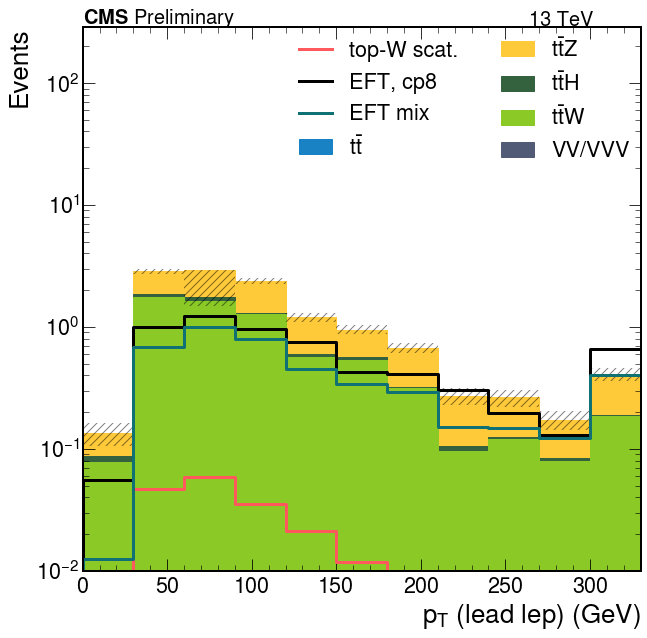

In [7]:
makePlot(output, 'lead_lep', 'pt',
         data=[],
         bins=pt_bins_coarse, log=True, normalize=False, axis_label=r'$p_{T}$ (lead lep) (GeV)',
         new_colors=my_colors, new_labels=my_labels,
         order=['diboson', 'TTW', 'TTH', 'TTZ', 'ttbar'],
         signals=['topW_v3', 'topW_EFT_cp8', 'topW_EFT_mix'],
        )

Data: 0 MC: 11.72


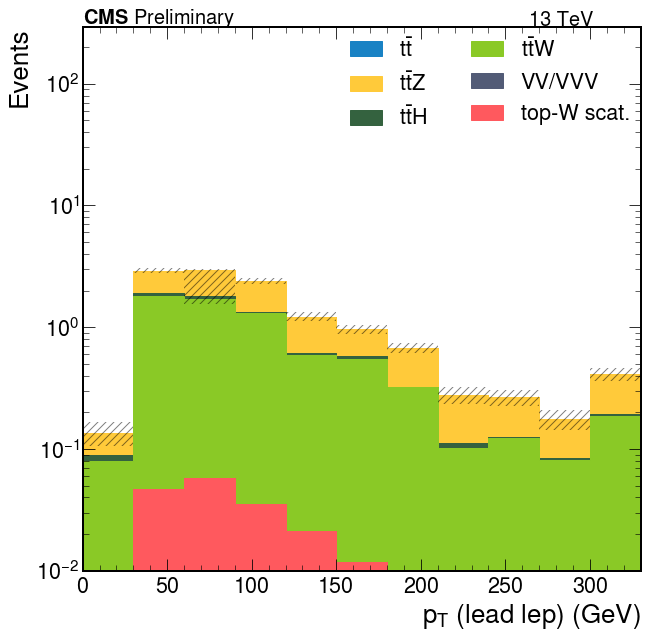

In [8]:
makePlot(output, 'lead_lep', 'pt',
         data=[],
         bins=pt_bins_coarse, log=True, normalize=False, axis_label=r'$p_{T}$ (lead lep) (GeV)',
         new_colors=my_colors, new_labels=my_labels,
         order=['topW_v3', 'diboson', 'TTW', 'TTH', 'TTZ', 'ttbar'],
         signals=[],
         omit=['topW_EFT_cp8', 'topW_EFT_mix'],
        )

Data: 0 MC: 11.72


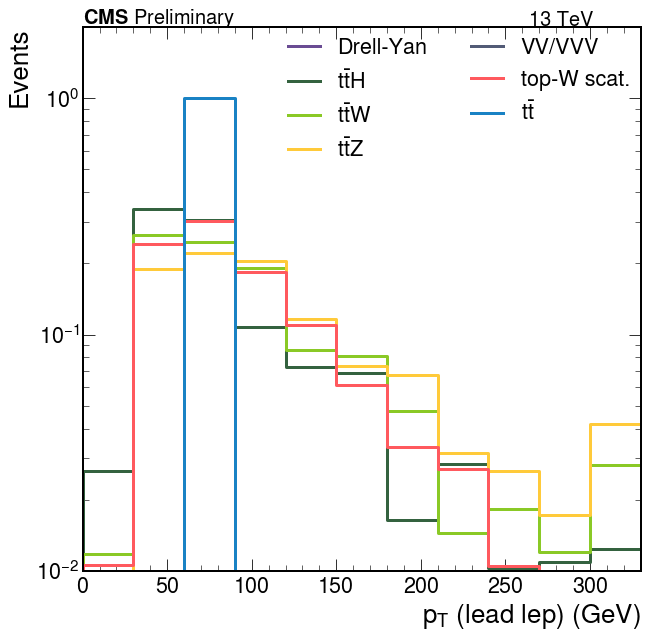

In [9]:
makePlot(output, 'lead_lep', 'pt',
         data=[],
         shape=True,
         bins=pt_bins_coarse, log=True, normalize=False, axis_label=r'$p_{T}$ (lead lep) (GeV)',
         new_colors=my_colors, new_labels=my_labels,
         omit=['topW_EFT_cp8', 'topW_EFT_mix'],
        )

Data: 0 MC: 17.34


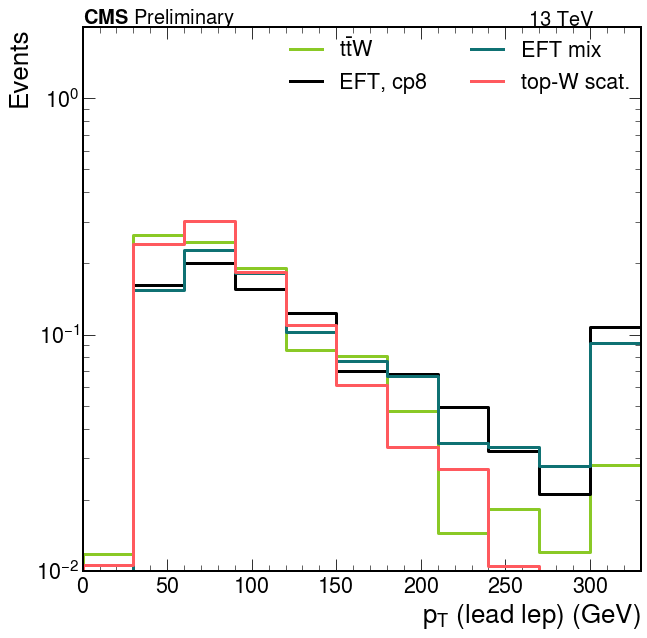

In [10]:
makePlot(output, 'lead_lep', 'pt',
         data=[],
         shape=True,
         bins=pt_bins_coarse, log=True, normalize=False, axis_label=r'$p_{T}$ (lead lep) (GeV)',
         new_colors=my_colors, new_labels=my_labels,
         omit=['DY', 'ttbar', 'TTZ', 'TTH', 'diboson'],
        )

Data: 0 MC: 8.21
Data: 0 MC: 8.21


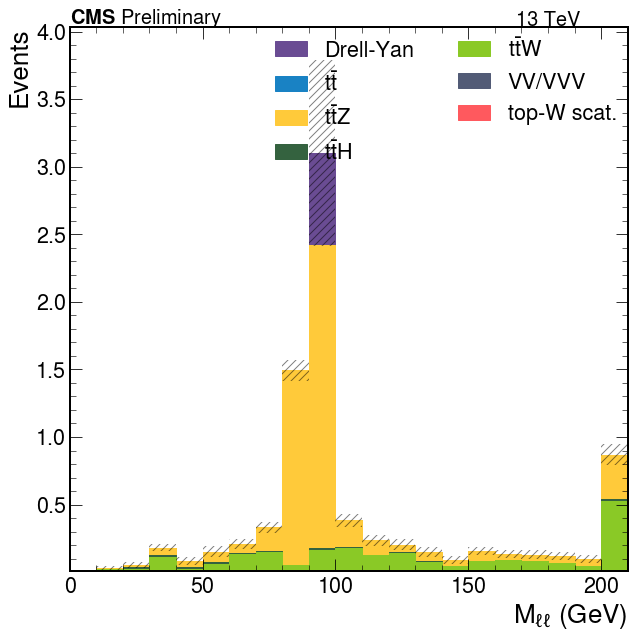

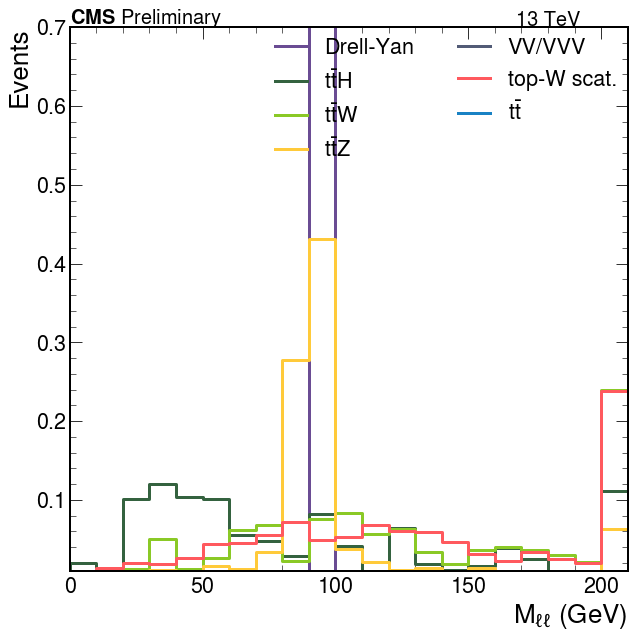

In [11]:
makePlot(output, 'dilep_mass', 'mass',
         bins=mass_bins, log=False, normalize=False, axis_label=r'$M_{\ell\ell}$ (GeV)',
         new_colors=my_colors, new_labels=my_labels,
         order=['topW_v3', 'diboson',  'TTW', 'TTH', 'TTZ', 'ttbar', 'DY'],
         omit=['topW_EFT_cp8', 'topW_EFT_mix'],
        )
makePlot(output, 'dilep_mass', 'mass',
         shape=True,
         bins=mass_bins, log=False, normalize=False, axis_label=r'$M_{\ell\ell}$ (GeV)',
         new_colors=my_colors, new_labels=my_labels,
         ymax=0.7,
         omit=['topW_EFT_cp8', 'topW_EFT_mix'],
        )

Data: 0 MC: 11.72


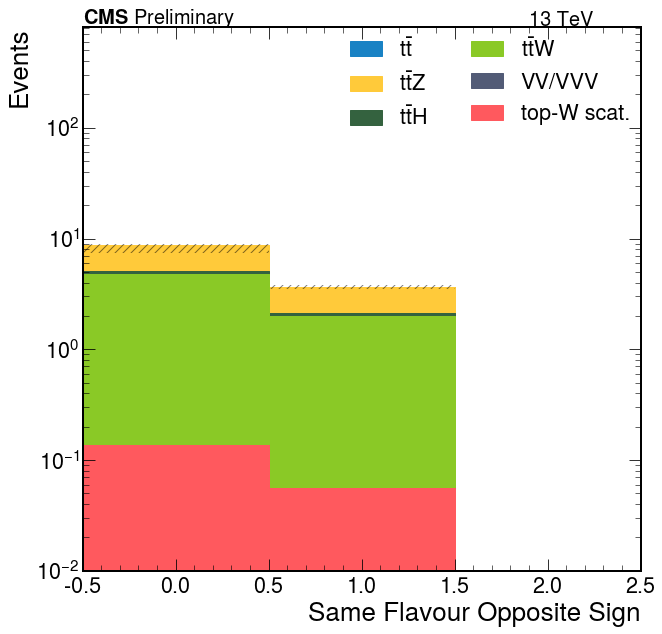

In [12]:
makePlot(output, 'N_SFOS', 'multiplicity',
         data=[],
         bins=hist.Bin('multiplicity', r'$N$', 2, -0.5, 1.5), log=True, normalize=False, axis_label='Same Flavour Opposite Sign',
         new_colors=my_colors, new_labels=my_labels,
         order=['topW_v3', 'diboson', 'TTW', 'TTH', 'TTZ', 'ttbar'],
         signals=[],
         omit=['topW_EFT_cp8', 'topW_EFT_mix'],
        )

Clearly the ttZ process dominates the N=1 bin because the Z-Boson decays into a single SF OS pair. If I change the binning a different process should occupy the N=2 bin?